In [1]:
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from collections import deque
import random as rand
import math
import matplotlib.pyplot as plt

In [2]:
import os
os.chdir('C:\\code\\activ')

In [3]:
df_name = 'nov_nine_var.xlsx'

In [4]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

np.set_printoptions(precision=6, suppress=True)

In [5]:
dnn_model = tf.keras.models.load_model('./model/dnn.h5')

In [6]:
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 100

GAMMA = 1.2
batch_size = 128
episode_done = 1000

In [7]:
df = pd.read_excel('./documents/'+df_name).iloc[:,1:23]

scaler = MinMaxScaler()
X = scaler.fit_transform(df.iloc[:,0:21])

In [8]:
df.iloc[:,21:22].iloc[-1]

수도권 과밀화율    0.503849
Name: 430, dtype: float64

In [9]:
def return_latest():
    df = pd.read_excel('./documents/'+df_name).iloc[:,1::]
    X = df.iloc[:,0:21]
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    latest = X[-1].reshape(1, 21)

    return latest

In [10]:
def return_state(action, state):
    if action % 2 == 0:
        var = -0.01
    
    else:
        var = 0.01

    j = int(action / 2)
    
    state[0][j] = state[0][j] + var
    next_state = state

    return next_state

In [11]:
def return_reward(state, y_pred):
    real_state = return_latest()

    dist = np.sqrt(np.sum(np.square(real_state-state)))

    a = tf.cast(tf.math.subtract(y_pred, 0.503849), dtype=tf.float32)
    b = tf.cast(dist, dtype=tf.float32)

    loss = tf.math.add(a, b)
    return tf.math.multiply(loss, 100)

In [12]:
class Dqn_agent:
    def __init__(self):
        self.target = self._create_model()
        self.model = self._create_model()

        self.target.set_weights(self.model.get_weights())

        self.memory = deque(maxlen=10000)
        
    def _create_model(self):
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(128, input_shape=(21, ), activation='relu'))
        model.add(tf.keras.layers.Dense(128, activation='relu'))
        model.add(tf.keras.layers.Dense(128, activation='relu'))
        model.add(tf.keras.layers.Dense(42, activation='linear'))

        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0)
        model.compile(optimizer=optimizer, loss='mse')

        return model

    def forward(self, x):
        x = self.model(x)
        return x
    
    def memorize(self, state, action, reward, next_state):
        self.memory.append((
            state, action,
            tf.cast(reward, tf.float16), next_state
        ))

    def act(self, state, episode):
        eps_threshold = EPS_END + ((EPS_START - EPS_END) * (10 / episode))
        if rand.random() > eps_threshold:
            return tf.convert_to_tensor([np.argmin(self.forward(state))]), eps_threshold
        else:
            return tf.convert_to_tensor([rand.randrange(42)]), eps_threshold

    def learn(self, episode):
        if len(self.memory) < batch_size:
            return

        batch = rand.sample(self.memory, batch_size)
        states, actions, rewards, next_states = zip(*batch)

        states = tf.convert_to_tensor(states).reshape(batch_size, 21) # (batch_size, 21)
        actions = tf.convert_to_tensor(actions) # (batch_size, )
        rewards = tf.convert_to_tensor(rewards).reshape(batch_size, 1) # (batch_size, )
        next_states = tf.convert_to_tensor(next_states).reshape(batch_size, 21) # (batch_size, 21)

        # print(f"s: {states.shape}, a: {actions.shape}, r: {rewards.shape}, ns: {next_states.shape}")

        current_q = self.model.predict(states, verbose=0)
        next_q = self.target.predict(next_states, verbose=0)

        # print(f"cq: {current_q.shape}, nq: {next_q.shape}")

        for i in range(batch_size):
            if episode == episode_done:
                next_q_value = rewards[i]
            else:
                next_q_value = rewards[i] + GAMMA * np.min(next_q[i])
            
            current_q[i, actions[i]] = next_q_value

        self.model.fit(states, current_q, batch_size=16, epochs=5, verbose=0)
        return self.model.evaluate(states, current_q, batch_size=batch_size, verbose=0)
        

In [13]:
agent = Dqn_agent()
sc_hist = []
st_hist = []
pop_hist = []

for e in range(1, 100):
    state = return_latest()
    steps = 0

    if e % 50 == 0:
        agent.target.set_weights(agent.model.get_weights())
    while True:
        pred_y = dnn_model.predict(state, verbose=0)

        action, eps = agent.act(state, e)

        next_state = return_state(action, state)
        reward = return_reward(state, pred_y)

        agent.memorize(state, action, reward, next_state)
        loss = agent.learn(e)

        state = next_state
        steps = steps + 1

        if steps % 200 == 0:
            print(f"steps: {steps}, reward: {reward[0][0]:.6f}, pop: {round(pred_y[0][0], 6)}, loss: {loss:.4f}")

        if steps == episode_done:
            print("=============episode done=============")
            print(f"episode: {e}, reward: {reward}, y_pred: {pred_y}, eps: {eps}")
            print("=======================================")
            sc_hist.append(reward)
            st_hist.append(state)
            pop_hist.append(pred_y)
            break

steps: 200, reward: 11.951863, pop: 0.5033680200576782, loss: 0.3053
steps: 400, reward: 15.422441, pop: 0.5031539797782898, loss: 0.2533
steps: 600, reward: 27.992785, pop: 0.5073710083961487, loss: 0.7113
steps: 800, reward: 28.645596, pop: 0.5056999921798706, loss: 1.6104
steps: 1000, reward: 28.218719, pop: 0.5067510008811951, loss: 1.5332
=============episode done=============
episode: 1, reward: [[28.21872]], y_pred: [[0.506751]], eps: 9.91
steps: 200, reward: 12.023467, pop: 0.5049200057983398, loss: 1.8542
steps: 400, reward: 16.193674, pop: 0.5045409798622131, loss: 1.3371
steps: 600, reward: 18.363180, pop: 0.5052719712257385, loss: 1.0891
steps: 800, reward: 23.866755, pop: 0.5050299763679504, loss: 1.0968
steps: 1000, reward: 30.267139, pop: 0.5071880221366882, loss: 1.3791
=============episode done=============
episode: 2, reward: [[30.26714]], y_pred: [[0.507188]], eps: 4.96
steps: 200, reward: 14.583820, pop: 0.5034000277519226, loss: 1.4208
steps: 400, reward: 21.254110

In [ ]:
len(pop_hist)

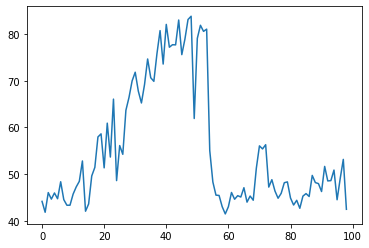

In [ ]:
plt.plot(np.array(pop_hist).reshape(len(pop_hist)))
plt.show()

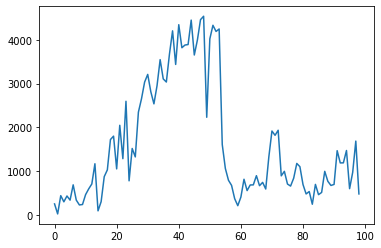

In [ ]:
plt.plot(np.array(sc_hist).reshape(len(sc_hist)))
plt.show()

In [ ]:
np_st_hist = np.array(st_hist)

In [ ]:
np_st_hist.shape

(99, 1, 21)

In [ ]:
result = np.array(st_hist).reshape(99, 21)
X_result = scaler.inverse_transform(result)
pop_result = np.array(pop_hist).reshape(99, 1)

In [ ]:
df = np.append(X_result, pop_result, axis=1)

In [ ]:
pd_df = pd.DataFrame(df)
pd_df.to_excel('./documents/result/dqn.xlsx')